In [8]:
from models import llm 
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from prompts import * 
from schemas import * 
from typing_extensions import TypedDict, Any, Annotated
import operator 
from langgraph.types import  Send 
from langgraph.graph import START, END, StateGraph
import pandas as pd


class State(TypedDict):
    text: str
    segments: Any
    flag: bool 
    error: str 
    segment: str
    tables : Annotated[List, operator.add]
    headers: Annotated[List, operator.add]
    rows: List 
    columns: List 


  
    
   


In [9]:
sample_text = """Here's sample medical-related text about a hypothetical drug you can use to test your table generation:

---

**Drug Name:** Medorin  
**Generic Name:** Metralex Sodium  
**Drug Class:** Nonsteroidal Anti-inflammatory Drug (NSAID)  

**Description:**  
Medorin (Metralex Sodium) is a nonsteroidal anti-inflammatory medication commonly prescribed to relieve pain, swelling, and inflammation associated with conditions such as rheumatoid arthritis, osteoarthritis, and acute musculoskeletal injuries. It acts by inhibiting the cyclooxygenase (COX) enzyme, thereby decreasing prostaglandin synthesis.

**Dosage Forms:**  
- Tablets: 100 mg, 200 mg, 400 mg  
- Oral Suspension: 50 mg/5 ml  

**Recommended Dosage:**  
- Adults: Typically 200–400 mg orally every 6 to 8 hours, not exceeding 1200 mg/day.  
- Pediatrics (age 6–12): 100 mg orally every 8 hours, maximum 300 mg/day.

**Contraindications:**  
- Known hypersensitivity to NSAIDs  
- Active gastrointestinal bleeding or ulcers  
- Severe hepatic impairment  
- Severe renal impairment  
- Pregnancy (third trimester)

**Common Side Effects:**  
- Nausea  
- Vomiting  
- Dyspepsia  
- Dizziness  
- Headache  

**Serious Adverse Effects:**  
- Gastrointestinal bleeding  
- Cardiovascular thrombotic events (e.g., stroke, myocardial infarction)  
- Renal impairment  
- Severe allergic reactions (anaphylaxis)

**Drug Interactions:**  
- Anticoagulants (increased bleeding risk)  
- Diuretics (reduced effectiveness of diuretics)  
- ACE inhibitors (reduced antihypertensive effect)  

**Storage Conditions:**  
Store tablets at room temperature (20–25°C / 68–77°F) away from moisture and direct sunlight.

**Manufacturer:** HealthGen Pharmaceuticals Ltd."""

In [10]:
header_extraction

'Please analyze the passage below to extract potential row and column headers. Use the following guidelines:\n\n- **Column Headers:**  \n  - Identify time periods (e.g., "01", "Jan", "2023") as column headers.\n  - Identify groups or cohorts (e.g., "Group A", "Control", "Male/Female") as column headers.\n\n- **Row Headers:**  \n  - Identify metric names (e.g., "Blood Pressure", "Revenue", "Satisfaction Score") as row headers.\n\n- **General Instructions:**  \n  - If the layout is unclear, follow typical report structures and avoid making guesses.\n\nReturn your output in JSON format as follows:\n{{\n  "row_headers": [List of strings],\n  "column_headers": [List of strings]\n}}\n\nPassage:\n{segment}\n'

In [67]:
def table_decision_node(state:State):
    text = state['text']
    prompt = PromptTemplate(template=table_decision)
    flag = (prompt | llm.with_structured_output(TableDecision)).invoke({"input_text": text}).needs_table 
    return {"flag": flag }



def break_segments(state:State):
    text = state['text']
    prompt = PromptTemplate(template=segment_passages)
    segments =  (prompt | llm.with_structured_output(PassageSegments)).invoke({"input_text": text}).passages
    return {"segments": segments} 


def continue_to_segments(state: State):
    return [Send("generate_header_node", {"segment": x}) for x in state["segments"]]

def generate_header_node(state:State):
    text = state['segment']
    prompt = PromptTemplate(template=header_extraction)
    out =  (prompt | llm.with_structured_output(HeaderExtractionOutput)).invoke({"segment": text})
    return {"headers": [(text, out.row_headers, out.column_headers)]} 


def continue_to_tables(state:State):
    return [Send("generate_table_node", {"segment": segment, "rows": rows, "columns": columns}) for segment, rows, columns in state["headers"]]


def generate_table_node(state: State):
    rows = state['rows']
    columns = state['columns']
    text = state['segment']

    # Check if we have a simple table vs. a key-value table
    if not rows or not columns:
        print('------------------------')
        print("Using simple table extraction")
        print(f"Rows: {rows}")
        print(f"Columns: {columns}")
        print(f"text: {text}")
        print('------------------------')
        
        # Determine table type:
        # If we only have rows, consider this a simple table (type 0)
        # If there is any other condition, you can decide on another type.
        if rows:
            headers = rows
            table_type = 0
        elif columns:
            headers = columns
            table_type = 1
        else:
            return {"tables": [(-1, text, "No table found", rows, columns)]}

        prompt = PromptTemplate(template=simple_table)
        out = (prompt | llm.with_structured_output(ExtractionResultSimple)).invoke({"passage": text, "headers": headers})
        return {"tables": [(table_type, text, out, rows, columns)]}
    else:
        # For a table with both rows and columns, we might decide it's type 1.
        table_type = 1
        prompt = PromptTemplate(template=extracted_table)
        out = (prompt | llm.with_structured_output(ExtractionResult)).invoke({"passage": text, "rows": rows, "columns": columns})
        return {"tables": [(table_type, text, out, rows, columns)]}



# def header_extraction_node(state:State):
#     text = state['text']
#     prompt = PromptTemplate(template=header_extraction)
#     out =  (prompt | llm.with_structured_output(HeaderExtractionOutput)).invoke({"segment": text})
#     return dict(rows=out.row_headers, columns=out.column_headers)


# def extracted_table_node(state:State):
#     rows = state['rows']
#     columns = state['columns']
#     text = state['text']
#     prompt = PromptTemplate(template=extracted_table)
#     out = (prompt | llm.with_structured_output(ExtractionResult)).invoke({"passage": text, "rows": rows, "columns": columns})
#     return dict(tables=out)  



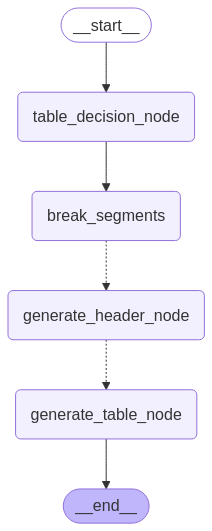

In [ ]:
graph_builder = StateGraph(State)
graph_builder.add_node("table_decision_node", table_decision_node) 
graph_builder.add_node("break_segments", break_segments)
graph_builder.add_node("generate_header_node", generate_header_node)
graph_builder.add_node("generate_table_node", generate_table_node)


graph_builder.add_edge(START, "table_decision_node")
graph_builder.add_edge("table_decision_node", "break_segments") 
graph_builder.add_conditional_edges("break_segments", continue_to_segments, ['generate_header_node'] )
graph_builder.add_conditional_edges("generate_header_node", continue_to_tables, ['generate_table_node'] )
graph_builder.add_edge("generate_table_node", END)

graph = graph_builder.compile()


from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [68]:
out = graph.invoke({'text':sample_text})

------------------------------------------------
Using simple table extraction
Rows: ['Pain Relief', 'Swelling Reduction', 'Inflammation Reduction', 'Rheumatoid Arthritis', 'Osteoarthritis', 'Acute Musculoskeletal Injuries', 'Cyclooxygenase (COX) Inhibition', 'Prostaglandin Synthesis Decrease']
Columns: []
text: **Description:**\nMedorin (Metralex Sodium) is a nonsteroidal anti-inflammatory medication commonly prescribed to relieve pain, swelling, and inflammation associated with conditions such as rheumatoid arthritis, osteoarthritis, and acute musculoskeletal injuries. It acts by inhibiting the cyclooxygenase (COX) enzyme, thereby decreasing prostaglandin synthesis.
------------------------

Using simple table extraction
Rows: ['Drug Name', 'Generic Name', 'Drug Class']
Columns: []
text: **Drug Information:**\n- **Drug Name:** Medorin\n- **Generic Name:** Metralex Sodium\n- **Drug Class:** Nonsteroidal Anti-inflammatory Drug (NSAID)
------------------------
------------------------
U

In [71]:
tables = out['tables']

for i, table_entry in enumerate(tables):
    table_type = table_entry[0]
    extraction_result = table_entry[2]
    table_data = extraction_result.model_dump()
    
    print(f"Table {i+1} - Table Type: {table_type}")
    print(table_data)
    print("------------------------\n")


Table 1 - Table Type: 0
{'data': [{'row_data': {'Drug Name': ['Medorin'], 'Generic Name': ['Metralex Sodium'], 'Drug Class': ['Nonsteroidal Anti-inflammatory Drug (NSAID)']}}]}
------------------------

Table 2 - Table Type: 0
{'data': [{'row_data': {'Pain Relief': ['Medorin (Metralex Sodium)'], 'Swelling Reduction': ['Medorin (Metralex Sodium)'], 'Inflammation Reduction': ['Medorin (Metralex Sodium)'], 'Rheumatoid Arthritis': ['Medorin (Metralex Sodium)'], 'Osteoarthritis': ['Medorin (Metralex Sodium)'], 'Acute Musculoskeletal Injuries': ['Medorin (Metralex Sodium)'], 'Cyclooxygenase (COX) Inhibition': ['Medorin (Metralex Sodium)'], 'Prostaglandin Synthesis Decrease': ['Medorin (Metralex Sodium)']}}]}
------------------------

Table 3 - Table Type: 0
{'data': [{'row': 'Tablets', 'columns': {'100 mg': '100 mg', '200 mg': '200 mg', '400 mg': '400 mg', '50 mg/5 ml': 'NA'}}, {'row': 'Oral Suspension', 'columns': {'100 mg': 'NA', '200 mg': 'NA', '400 mg': 'NA', '50 mg/5 ml': '50 mg/5 ml'}}

TypeError: 'int' object is not subscriptable

In [23]:
table['data']

[{'row_data': {'Drug Name': ['Medorin'],
   'Generic Name': ['Metralex Sodium'],
   'Drug Class': ['Nonsteroidal Anti-inflammatory Drug (NSAID)']}}]